In [95]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import matplotlib
import warnings
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [2]:
df_ad = pd.read_csv('cleaned_ads_data.csv')
df_nonad = pd.read_csv('cleaned_nonads_data.csv')
df_ad['y'] = df_ad['y'].map({1:'да', 0:'нет'})
df_nonad['y'] = df_nonad['y'].map({1:'да', 0:'нет'})


In [3]:
frequent_ad = pd.Series(' '.join(df_ad.value).split()).value_counts()[:30]
frequent_nonad = pd.Series(' '.join(df_nonad.value).split()).value_counts()[:30]

<Figure size 1080x720 with 0 Axes>

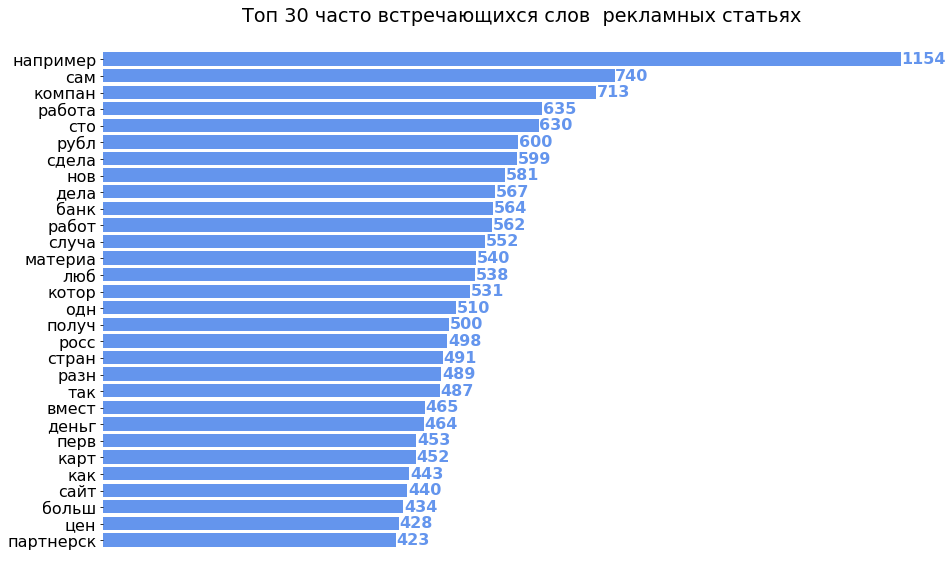

In [11]:
plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(15, 10))
width = 0.05
ind = np.arange(len(frequent_ad))
ax.barh(frequent_ad.index.values, frequent_ad.values, color = '#6495ED', align = 'center')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(frequent_ad.index.values, minor = False)
for i, v in enumerate(frequent_ad.values):
    ax.text(v + 1, i + 0.27, str(v), fontweight='bold', color='#6495ED')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.invert_yaxis()
plt.title("Топ 30 часто встречающихся слов  рекламных статьях")
matplotlib.rcParams.update({'font.size': 16})
plt.show()


<Figure size 1080x720 with 0 Axes>

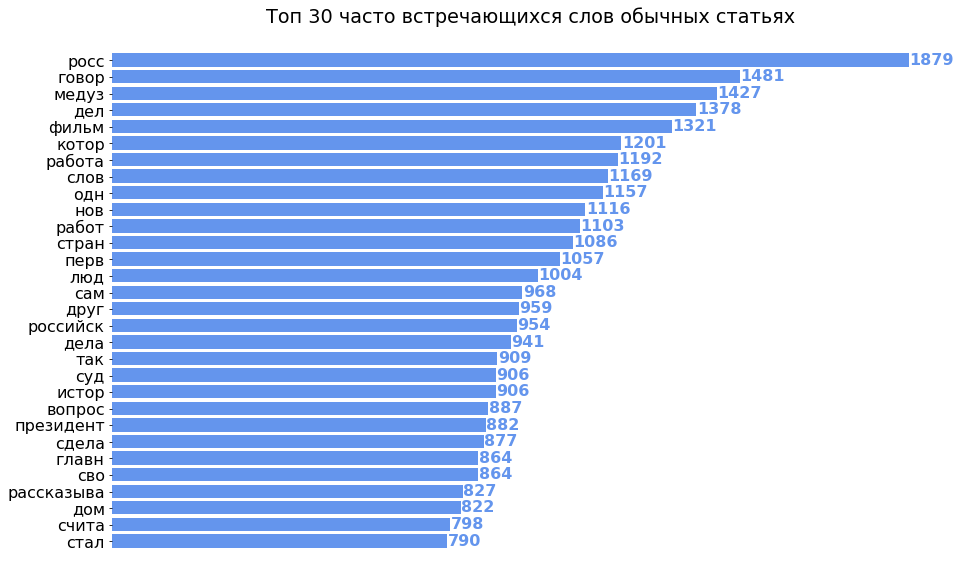

In [5]:
plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(15, 10))
width = 0.05
ind = np.arange(len(frequent_nonad))
ax.barh(frequent_nonad.index.values, frequent_nonad.values, color = '#6495ED', align = 'center')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(frequent_nonad.index.values, minor = False)
for i, v in enumerate(frequent_nonad.values):
    ax.text(v + 1, i + 0.27, str(v), fontweight='bold', color='#6495ED')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.invert_yaxis()
plt.title("Топ 30 часто встречающихся слов обычных статьях")
matplotlib.rcParams.update({'font.size': 16})
plt.show()

As we can see above word материа и партнерск will give us overfitting to meduza's posts, we need to get rid of it
On meduza we can find a lot of political articles we need to get rid of word that can overfit to that articles
So we get rid of some political_words

In [6]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
overfit_ad = ['материа', 'медуз', 'партнерск']
overfit_nonad = ['росс', 'медуз', 'президент', 'российск']
for i in range(len(df_ad)):
    df_ad.ix[i].value = [item for item in df_ad.iloc[i].value.split() if item not in overfit_ad]
    df_ad.ix[i].value = [' '.join(item for item in df_ad.iloc[i].value)]
for i in range(len(df_nonad)):
    df_nonad.ix[i].value = [item for item in df_nonad.iloc[i].value.split() if item not in overfit_nonad]
    df_nonad.ix[i].value = [' '.join(item for item in df_nonad.iloc[i].value)]
df_ad['value'] = [' '.join(item) for item in df_ad['value']]
df_nonad['value'] = [' '.join(item) for item in df_nonad['value']]

In [7]:
df = pd.concat([df_ad, df_nonad])
df.reset_index(drop=True, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df['count_word'] = df["value"].apply(lambda x: len(str(x).split()))
df['count_unique_word'] = df["value"].apply(lambda x: len(set(str(x).split())))
df['count_letters']=df["value"].apply(lambda x: len(str(x)))
df['mean_word_len'] = df["value"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df['unique_percent'] = df['count_unique_word'] * 100 / df['count_word']

Text(0.5,1,'Количесто слов в каждой статье')

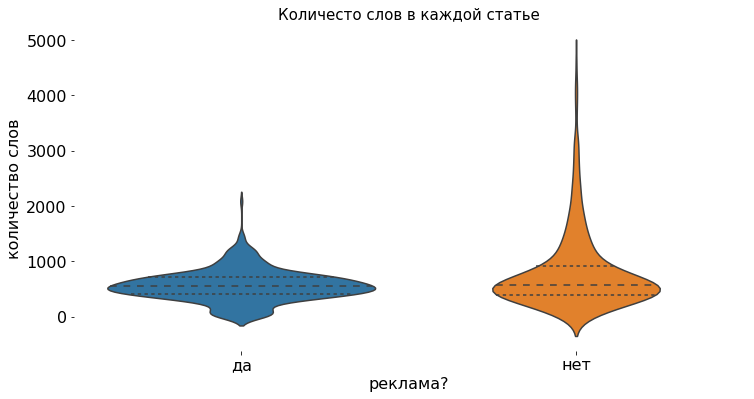

In [9]:
plt.figure(figsize=(12,6))
plt.subplot()
sns.violinplot(y='count_word', x = 'y', data = df, inner='quart')
plt.xlabel('реклама?', fontsize=16)
plt.ylabel('количество слов', fontsize=16)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.title("Количесто слов в каждой статье", fontsize=15)

As we can see above that ad articles have a count_word around 500

In [12]:
temp_df = pd.melt(df,value_vars=['count_word', 'count_unique_word'], id_vars='y')
temp_df['реклама?'] = temp_df['y']

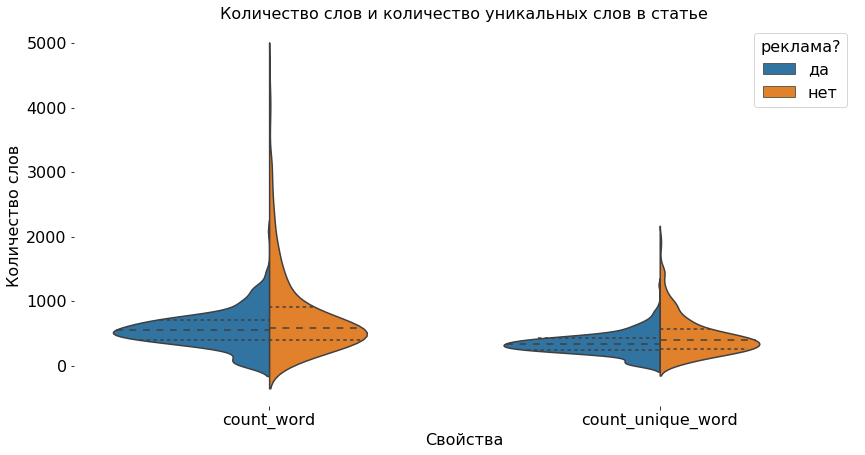

In [13]:
plt.figure(figsize=(14,7))
sns.violinplot(x='variable', y='value', hue='реклама?', data=temp_df,split=True,inner='quartile')
plt.title("Количество слов и количество уникальных слов в статье", fontsize=16)
plt.xlabel("Свойства", fontsize=16)
plt.ylabel("Количество слов", fontsize=16)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

Text(0.5,1,'Процент уникальных слов из всех слов в статьях')

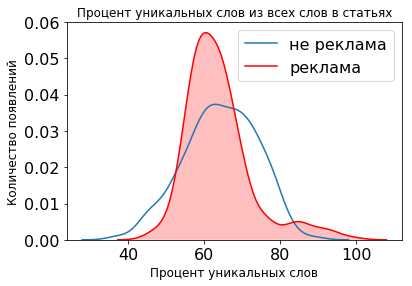

In [14]:
ax = sns.kdeplot(df[df['y'] == "нет"]['unique_percent'], label = 'не реклама')
ax = sns.kdeplot(df[df['y'] == "да"].unique_percent, label = "реклама", shade=True, color='r')
plt.ylabel('Количество появлений',fontsize=12)
plt.xlabel('Процент уникальных слов', fontsize=12)
plt.title('Процент уникальных слов из всех слов в статьях', fontsize=12)

In [15]:
df['y'] = df['y'].map({'да':1, 'нет': 0})

In [16]:
df['bigram'] = 2
df = df.copy()
for i in range(len(df.bigram)):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(word_tokenize(df.iloc[i].value))
    df.loc[i, 'bigram'] = [finder.nbest(bigram_measures.pmi, 10)]

In [17]:
df['trigram'] = 3
df = df.copy()
for i in range(len(df.trigram)):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = TrigramCollocationFinder.from_words(word_tokenize(df.iloc[i].value))
    df.loc[i, 'trigram'] = [finder.nbest(trigram_measures.pmi, 3)]

In [21]:
y = df['y']
x = df.drop('y',axis=1)

In [119]:
vect = TfidfVectorizer(max_features=700)
x_dtm = vect.fit_transform(x['value'])
clf = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(x_dtm, y, random_state=42, test_size=0.3)
clf.fit(x_train.toarray(), y_train)
clf.score(x_test.toarray(), y_test)

0.9217687074829932

In [120]:
vect = TfidfVectorizer(max_features=700)
x_dtm = vect.fit_transform(x['value'])
clf = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(x_dtm, y, random_state=42, test_size=0.3)
clf.fit(x_train.toarray(), y_train)
clf.score(x_test.toarray(), y_test)

0.9489795918367347